# Deep Neural Network for Breast Cancer Classification

## Introduction

In this project, we build and train a deep neural network for classification using **PyTorch**.  
The model is trained on the **Breast Cancer Wisconsin (Diagnostic) Dataset**, a well-known dataset for distinguishing between malignant and benign tumors.

## Setup

For this lab, we will be using the following libraries:

- **pandas** → for managing and manipulating the data  
- **numpy** → for numerical and mathematical operations  
- **matplotlib** → for data visualization and plotting  
- **scikit-learn (sklearn)** → for machine learning utilities and pipeline functions  
- **torch (PyTorch)** → for building and training the deep neural network  
- **ucimlrepo** → for loading the Breast Cancer Wisconsin (Diagnostic) dataset


In [1]:
%pip install pandas==2.2.2
%pip install numpy==1.26.4
%pip install matplotlib==3.8.0
%pip install scikit-learn==1.5.0
%pip install torch==2.3.1
%pip install ucimlrepo==0.0.7

## Dataset

The [Breast Cancer Wisconsin (Diagnostic)](https://archive.ics.uci.edu/dataset/17/breast+cancer+wisconsin+diagnostic) dataset is a classic benchmark used for classification tasks.  

It contains **569 samples** of breast cancer cells, each described by **30 features**. The dataset is divided into two classes: **benign** and **malignant**. The objective is to correctly classify the cells into one of these two categories.

This dataset is free to use and is licensed under the **Creative Commons Attribution 4.0 International (CC BY 4.0)** license.

First, we will load the dataset and explore its structure.


In [2]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
breast_cancer_wisconsin_diagnostic = fetch_ucirepo(id=17)

# data (as pandas dataframes)
X = breast_cancer_wisconsin_diagnostic.data.features
y = breast_cancer_wisconsin_diagnostic.data.targets

# print the first few rows of the data
display(X.head())

# print the first few rows of the target
display(y.head())

,radius1,texture1,perimeter1,area1,smoothness1,compactness1,concavity1,concave_points1,symmetry1,fractal_dimension1,...,radius3,texture3,perimeter3,area3,smoothness3,compactness3,concavity3,concave_points3,symmetry3,fractal_dimension3
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


,Diagnosis
0,M
1,M
2,M
3,M
4,M


Then let us check the shape of the dataset.

In [3]:
display(f'X shape: {X.shape}')
display(f'y shape: {y.shape}')

'X shape: (569, 30)'

'y shape: (569, 1)'

As we can see, the dataset contains **569 samples** and **30 features**.

The target variable is the **diagnosis** column, which specifies the class label for each sample:  

- **M** → Malignant  
- **B** → Benign  


Next, we will check the distribution of the target variable to understand the class balance in the dataset.

In [4]:
display(y['Diagnosis'].value_counts())

,count
Diagnosis,
B,357
M,212


Note that the dataset is **imbalanced**, with more samples labeled as **benign (B)** than **malignant (M)**.  

To create a balanced subset for training, we will randomly select:

- **200 malignant (M) samples**  
- **200 benign (B) samples**

This will give us a total of **400 samples** with an equal class distribution.

In [5]:
import pandas as pd

# Combine features and target into a single DataFrame for easier manipulation
data = pd.concat([X, y], axis=1)

# Separate the two classes
data_B = data[data['Diagnosis'] == 'B']
data_M = data[data['Diagnosis'] == 'M']

# Select 200 samples from each class
data_B = data_B.sample(n=200, random_state=42)
data_M = data_M.sample(n=200, random_state=42)

# Combine the two classes
balanced_data = pd.concat([data_B, data_M])

display(balanced_data['Diagnosis'].value_counts())

,count
Diagnosis,
B,200
M,200


After sampling, we now have **200 samples** in each class, making a total of **400 samples**.  
This means the dataset is **balanced**, with an equal distribution of benign and malignant cases.

We will split the dataset into:  
- **80% for training** (320 samples)  
- **20% for testing** (80 samples)

## Data Preprocessing

Before feeding the data into our neural network, we need to preprocess it.  
This involves the following steps:

1. **Separating features and labels** – Extract the input features (X) and the target labels (y).  
2. **Splitting the data** – Divide the dataset into training and test sets (80% training, 20% testing).  
3. **Standardizing feature values** – Normalize the feature values so that each has zero mean and unit variance.  

   This ensures that the neural network trains more efficiently and prevents features with larger scales from dominating the learning process.


In [6]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch

# Separate features and targets
X = balanced_data.drop('Diagnosis', axis=1)
y = balanced_data['Diagnosis']

# Convert the targets to binary labels
y = y.map({'B': 0, 'M': 1})

display(X)
display(y)

,radius1,texture1,perimeter1,area1,smoothness1,compactness1,concavity1,concave_points1,symmetry1,fractal_dimension1,...,radius3,texture3,perimeter3,area3,smoothness3,compactness3,concavity3,concave_points3,symmetry3,fractal_dimension3
395,14.060,17.18,89.75,609.1,0.08045,0.05361,0.026810,0.03251,0.1641,0.05764,...,14.92,25.34,96.42,684.5,0.10660,0.12310,0.08460,0.07911,0.2523,0.06609
110,9.777,16.99,62.50,290.2,0.10370,0.08404,0.043340,0.01778,0.1584,0.07065,...,11.05,21.47,71.68,367.0,0.14670,0.17650,0.13000,0.05334,0.2533,0.08468
481,13.900,19.24,88.73,602.9,0.07991,0.05326,0.029950,0.02070,0.1579,0.05594,...,16.41,26.42,104.40,830.5,0.10640,0.14150,0.16730,0.08150,0.2356,0.07603
493,12.460,12.83,78.83,477.3,0.07372,0.04043,0.007173,0.01149,0.1613,0.06013,...,13.19,16.36,83.24,534.0,0.09439,0.06477,0.01674,0.02680,0.2280,0.07028
136,11.710,16.67,74.72,423.6,0.10510,0.06095,0.035920,0.02600,0.1339,0.05945,...,13.33,25.48,86.16,546.7,0.12710,0.10280,0.10460,0.06968,0.1712,0.07343
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
257,15.320,17.27,103.20,713.3,0.13350,0.22840,0.244800,0.12420,0.2398,0.07596,...,17.73,22.66,119.80,928.8,0.17650,0.45030,0.44290,0.22290,0.3258,0.11910
328,16.270,20.71,106.90,813.7,0.11690,0.13190,0.147800,0.08488,0.1948,0.06277,...,19.28,30.38,129.80,1121.0,0.15900,0.29470,0.35970,0.15830,0.3103,0.08200
199,14.450,20.22,94.49,642.7,0.09872,0.12060,0.118000,0.05980,0.1950,0.06466,...,18.33,30.12,117.90,1044.0,0.15520,0.40560,0.49670,0.18380,0.4753,0.10130
194,14.860,23.21,100.40,671.4,0.10440,0.19800,0.169700,0.08878,0.1737,0.06672,...,16.08,27.78,118.60,784.7,0.13160,0.46480,0.45890,0.17270,0.3000,0.08701


,Diagnosis
395,0
110,0
481,0
493,0
136,0
...,...
257,1
328,1
199,1
194,1


The data will be split into **80% training** and **20% testing**.
  
After splitting, we will print the shapes of the training and test sets to verify that the data has been divided correctly.

In [7]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

display(f'X_train shape: {X_train.shape}')
display(f'y_train shape: {y_train.shape}')
display(f'X_test shape: {X_test.shape}')
display(f'y_test shape: {y_test.shape}')

'X_train shape: (320, 30)'

'y_train shape: (320,)'

'X_test shape: (80, 30)'

'y_test shape: (80,)'

## Feature Standardization

Next, we standardize the feature values using **StandardScaler** from *scikit-learn*.  

Standardization transforms the features so that they have a **mean of 0** and a **standard deviation of 1**.  
This ensures that all features contribute equally to the result and helps the model converge faster during training.

The process includes:
1. **Fitting the Scaler** – Calculate the mean and standard deviation for each feature in the training set using the `fit` method of the StandardScaler.  
2. **Transforming the Training Data** – Apply the standardization to the training data using the `transform` method.  
3. **Transforming the Test Data** – Apply the same transformation to the test data using the same scaler to maintain consistency.  

By standardizing the data, we ensure that each feature contributes equally to the training process, leading to better performance and faster convergence of the neural network.  

Finally, we convert the NumPy arrays into **PyTorch tensors**, which will be used as input to our deep neural network.


In [8]:
from torch.utils.data import DataLoader, TensorDataset

# Standardize the data
# Initialize the StandardScaler
scaler = StandardScaler()
# Fit the scaler on the training data and transform it
X_train = scaler.fit_transform(X_train)
# Transform the test data using the same scaler
X_test = scaler.transform(X_test)

# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train.values, dtype=torch.long)
y_test = torch.tensor(y_test.values, dtype=torch.long)

# Create DataLoader for training and test sets
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False)

## Build and Train the Neural Network Model

We will define our neural network architecture, specify the loss function and optimizer, and then train the model.

First, we define the neural network architecture using the **`nn.Module`** class in **PyTorch**.  
Our model consists of:  
- An **input layer**  
- One **hidden layer**  
- An **output layer** with **2 neurons** corresponding to the two classes (benign and malignant)  

Below is an example of the neural network architecture:  

<p align="left">
  <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/j-MFHvfzhrY04qVMsClOGA/8-8-2.jpg" alt="Neural Network Architecture" width="500"/>
</p>

This example has **8 neurons in the input layer**, **8 neurons in the hidden layer**, and **2 neurons in the output layer**.


In [9]:
import torch.nn as nn

class ClassificationNet(nn.Module):
    def __init__(self, input_units=30, hidden_units=64, output_units=2):
        super(ClassificationNet, self).__init__()
        self.fc1 = nn.Linear(input_units, hidden_units)
        self.fc2 = nn.Linear(hidden_units, output_units)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Instantiate the model
model = ClassificationNet(input_units=30, hidden_units=64, output_units=2)

Let us visualize the neural network architecture.

In [10]:
print(model)

ClassificationNet(
  (fc1): Linear(in_features=30, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=2, bias=True)
)


Next, we define the **loss function** and **optimizer** for training the model.  

- **Loss Function**: We use `CrossEntropyLoss`, which is commonly applied to multi-class classification problems.  
- **Optimizer**: We use the `Adam` optimizer, which adapts the learning rate during training and helps achieve faster convergence compared to standard stochastic gradient descent (SGD).  

Together, these ensure that the model learns to minimize classification errors while updating its weights efficiently during training.

In [11]:
import torch.optim as optim

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


We now train the model using the training dataset.  

The process involves iterating over the training data for a specified number of **epochs** and updating the network’s weights using **backpropagation**.

During training:

- At each epoch, we calculate the **loss**.  
- The loss values are printed to monitor training progress.  
- Ideally, the loss should **decrease over time** as the model learns to classify correctly.  

After training, we evaluate the model on the **test dataset** to measure its performance on unseen data and assess its ability to generalize.

In [12]:
epochs = 10
train_losses = []
test_losses = []

for epoch in range(epochs):
    # Training phase
    model.train()
    running_loss = 0.0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)

    # Evaluation phase on test set
    model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            test_outputs = model(X_batch)
            loss = criterion(test_outputs, y_batch)
            test_loss += loss.item()

    test_loss /= len(test_loader)
    test_losses.append(test_loss)

    print(f'Epoch [{epoch + 1}/{epochs}], Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')

Epoch [1/10], Train Loss: 0.2711, Test Loss: 0.1905
Epoch [2/10], Train Loss: 0.1193, Test Loss: 0.1424
Epoch [3/10], Train Loss: 0.0924, Test Loss: 0.1199
Epoch [4/10], Train Loss: 0.0760, Test Loss: 0.1170
Epoch [5/10], Train Loss: 0.0725, Test Loss: 0.0994
Epoch [6/10], Train Loss: 0.0653, Test Loss: 0.0985
Epoch [7/10], Train Loss: 0.0607, Test Loss: 0.0934
Epoch [8/10], Train Loss: 0.0546, Test Loss: 0.0890
Epoch [9/10], Train Loss: 0.0499, Test Loss: 0.0870
Epoch [10/10], Train Loss: 0.0470, Test Loss: 0.0893


## Overview

- **Training Loss** steadily decreased from **0.2711 → 0.0470**, showing that the model successfully learned patterns in the training data.  

- **Test Loss** decreased from **0.1905 → 0.0870** (with slight fluctuations), suggesting that the model generalizes well to unseen data.  

- The small **gap between training and test loss** means the model is **not overfitting**, it’s learning representations that transfer to test data.

- Both losses stabilized around **epoch 8–10**, indicating that further training may only provide marginal improvements unless we adjust hyperparameters or model size.  

## Conclusion
The neural network shows **good convergence and generalization** within 10 epochs. Loss curves suggest that the model is learning effectively and is unlikely to be overfitting.


## Training vs Test Loss

Plotting the loss curves helps us understand the training dynamics of our model.

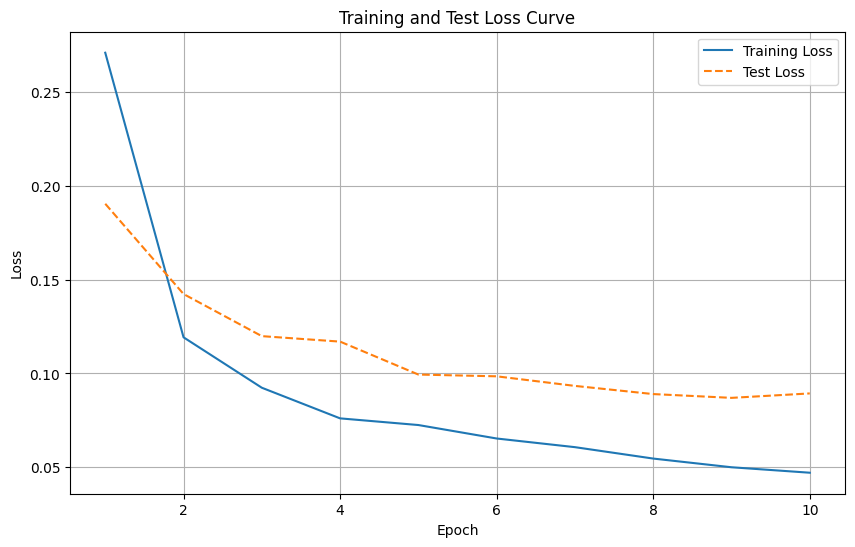

In [13]:
import matplotlib.pyplot as plt

# Plot the loss curves
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, epochs + 1), test_losses, label='Test Loss', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss Curve')
plt.legend()
plt.grid(True)
plt.show()

### Conclusion from the Training and Test Loss Curve

From the observed loss curves, we can conclude the following:

- The **training loss** decreases consistently across epochs, indicating that the model is effectively learning from the training data.

- The **test loss** also decreases and then stabilizes, showing that the model generalizes well to unseen data.

- The gap between the training and test loss remains small, suggesting that there is no significant overfitting.  

- Overall, the model demonstrates **stable learning behavior**, converges smoothly, and achieves good performance on both training and test datasets.